## Analyzing 2016 Presidential Election Data
### - Pedram Pourdavood

In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## 1. Independent Data Exploration


This data was downloaded from http://classic.fec.gov/disclosurep/PDownload.do

In [2]:
# load the data
donations = Table.read_table("Data/donations.csv")
donations.show(5) 

cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,tran_id,election_tp
P80001571,"Trump, Donald J.","PUTNAM, MATTHEW",MADISON,AL,35756,INFORMATION REQUESTED,INFORMATION REQUESTED,88.76,15-SEP-16,nan,X,nan,SA18,1146165,SA18.109837,G2016,nan
P00003392,"Clinton, Hillary Rodham","CROSS, JOYCE",HUNTSVILLE,AL,3.58013e+08,RETIRED,HOMEMAKER,115,11-APR-16,nan,X,* HILLARY VICTORY FUND,SA18,1091718,C4706538,P2016,nan
P80001571,"Trump, Donald J.","SHARP, MARY MS.",DECATUR,AL,35603,RETIRED,RETIRED,80,20-NOV-16,nan,X,nan,SA18,1146165,SA18.130647,G2016,nan
P80001571,"Trump, Donald J.","STAMPS, HAROLD MR.",ALBERTVILLE,AL,35951,RETIRED,RETIRED,-28,13-OCT-16,nan,X,nan,SA18,1146165,SA18.194304,G2016,nan
P80001571,"Trump, Donald J.","STAMPS, HAROLD MR.",ALBERTVILLE,AL,35951,RETIRED,RETIRED,-28,20-OCT-16,nan,X,nan,SA18,1146165,SA18.194305,G2016,nan


#### For some reason when I load the data, all the columns are off by one in terms of position, so I'm going to do some relabeling and selecting columns I want.

In [3]:
# Chooseing appropriate columns
donations = donations.select(1, 9, 8, 7, 2, 16)
donations.show(5)

cand_id,contb_receipt_amt,contbr_occupation,contbr_employer,cand_nm,tran_id
"Trump, Donald J.",15-SEP-16,88.76,INFORMATION REQUESTED,"PUTNAM, MATTHEW",G2016
"Clinton, Hillary Rodham",11-APR-16,115,HOMEMAKER,"CROSS, JOYCE",P2016
"Trump, Donald J.",20-NOV-16,80,RETIRED,"SHARP, MARY MS.",G2016
"Trump, Donald J.",13-OCT-16,-28,RETIRED,"STAMPS, HAROLD MR.",G2016
"Trump, Donald J.",20-OCT-16,-28,RETIRED,"STAMPS, HAROLD MR.",G2016


In [4]:
# Relabling columns
donations = donations.relabeled(make_array("cand_id", "contbr_employer", "contbr_occupation", "contb_receipt_amt", "tran_id", "cand_nm"), 
                                make_array("CandName", "ContOccupation", "Amount", "Date", "ElectionType", "ContName"))

In [5]:
donations.set_format(2, CurrencyFormatter)
donations.show(5)

CandName,Date,Amount,ContOccupation,ContName,ElectionType
"Trump, Donald J.",15-SEP-16,$88.76,INFORMATION REQUESTED,"PUTNAM, MATTHEW",G2016
"Clinton, Hillary Rodham",11-APR-16,$115.00,HOMEMAKER,"CROSS, JOYCE",P2016
"Trump, Donald J.",20-NOV-16,$80.00,RETIRED,"SHARP, MARY MS.",G2016
"Trump, Donald J.",13-OCT-16,$-28.00,RETIRED,"STAMPS, HAROLD MR.",G2016
"Trump, Donald J.",20-OCT-16,$-28.00,RETIRED,"STAMPS, HAROLD MR.",G2016


As we can see, there are negatives numbers in our Amount column. This is beacuse in the elections, if someone exceeds the maximum amount, they can refer someone in ther family to pay the extra amount and this is indicated as a negative number. In order to reduce confusion, I'm going to take the absolute value of the amounts. 

In [6]:
donations = donations.with_column("Amount", donations.apply(np.abs, "Amount"))
donations.show(5)

CandName,Date,Amount,ContOccupation,ContName,ElectionType
"Trump, Donald J.",15-SEP-16,$88.76,INFORMATION REQUESTED,"PUTNAM, MATTHEW",G2016
"Clinton, Hillary Rodham",11-APR-16,$115.00,HOMEMAKER,"CROSS, JOYCE",P2016
"Trump, Donald J.",20-NOV-16,$80.00,RETIRED,"SHARP, MARY MS.",G2016
"Trump, Donald J.",13-OCT-16,$28.00,RETIRED,"STAMPS, HAROLD MR.",G2016
"Trump, Donald J.",20-OCT-16,$28.00,RETIRED,"STAMPS, HAROLD MR.",G2016


The following data was taken from http://classic.fec.gov/disclosurep/PCandList.do

In [7]:
# Load the second table
candidates = Table.read_table("Data/candidate-list.csv")
candidates.show(5)

cand_id,cand_nm,cand_nm_title,cand_pty_aff,contb_receipt_amt,ind_contrib,pac_contrib,party_contrib,cand_contrib,disbursements,coh_cop,other_contrib,debt,date_through,election_yr
P00003392,"Clinton, Hillary Rodham","Clinton, Hillary Rodham",Democratic Party,"$563,754,017","$399,669,230","$1,783,251","$20,039","$1,450,335","$563,430,700","$323,317","$160,831,162",$183,12/31/16,2016
P80001571,"Trump, Donald J.","Trump, Donald J.",Republican Party,"$333,127,164","$132,233,015","$144,534","$9,303","$66,141,714","$325,334,388","$7,611,703","$134,598,598",$0,12/31/16,2016
P60007168,"Sanders, Bernard","Sanders, Bernard",Democratic Party,"$228,164,501","$226,581,901","$5,622",$0,$0,"$222,709,340","$5,473,008","$1,576,978","$449,409",12/31/16,2016
P60006111,"Cruz, Rafael Edward 'Ted'","Cruz, Rafael Edward 'Ted'",Republican Party,"$90,203,164","$88,737,586","$93,195",$0,$0,"$86,526,777","$33,852","$1,372,383",$0,12/31/16,2016
P60005915,"Carson, Benjamin S.","Carson, Benjamin S.",Republican Party,"$63,622,854","$62,163,780","$5,588",$0,$0,"$63,062,103","$560,751","$1,453,486",$0,12/31/16,2016


## Visualizations and Grouping

In [8]:
donations.show(3)

CandName,Date,Amount,ContOccupation,ContName,ElectionType
"Trump, Donald J.",15-SEP-16,$88.76,INFORMATION REQUESTED,"PUTNAM, MATTHEW",G2016
"Clinton, Hillary Rodham",11-APR-16,$115.00,HOMEMAKER,"CROSS, JOYCE",P2016
"Trump, Donald J.",20-NOV-16,$80.00,RETIRED,"SHARP, MARY MS.",G2016


In [9]:
# Total donation for each candidate sorted in ascending order
# I am grouping by the Candidate name and summing up the donations for each candidate
total_donation = donations.select("CandName", "Amount").group(0, sum).sort("Amount sum", descending=True)
total_donation.set_format(1, CurrencyFormatter)

CandName,Amount sum
"Trump, Donald J.","$2,039,976.42"
"Clinton, Hillary Rodham","$1,943,972.54"
"Cruz, Rafael Edward 'Ted'","$902,699.53"
"Carson, Benjamin S.","$620,632.17"
"Rubio, Marco","$579,958.73"
"Sanders, Bernard","$314,898.79"
"Bush, Jeb","$288,199.00"
"Huckabee, Mike","$90,116.50"
"Paul, Rand","$60,287.37"
"Kasich, John R.","$55,783.00"


#### As we can see, Trump had the most donations in the 2016 election, followed by Clinton, Cruz, and Carson.

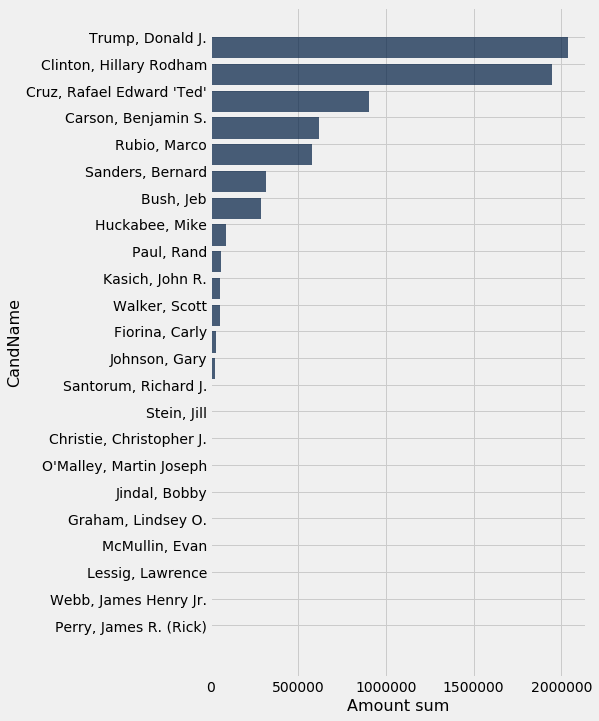

In [10]:
# A bar chart for total donations for each 
total_donation.barh(0) 

#### One thing said during the elections was that Trump and Hillary take donations from the very rich, while Bernie made use of much smaller contributions from those who weren't as wealthy. Let's see if this were true.

In [11]:
average_donations = donations.select("CandName", "Amount").group(0, np.mean).sort("Amount mean", descending=True)
average_donations.show(23)

CandName,Amount mean
"Bush, Jeb",980.269
"Jindal, Bobby",689.75
"Walker, Scott",550.554
"Rubio, Marco",503
"Lessig, Lawrence",500
"Santorum, Richard J.",482.957
"Huckabee, Mike",400.518
"O'Malley, Martin Joseph",361.33
"Perry, James R. (Rick)",300
"Johnson, Gary",295.732


#### As we can see, Bernie Sanders had the lowest average for donations (Only 44 dollars! ). Whereas Trump and Clinton's averages were 155 and 98 dollars resectively.
#### Jeb Bush had the highest average amongst the candidates.

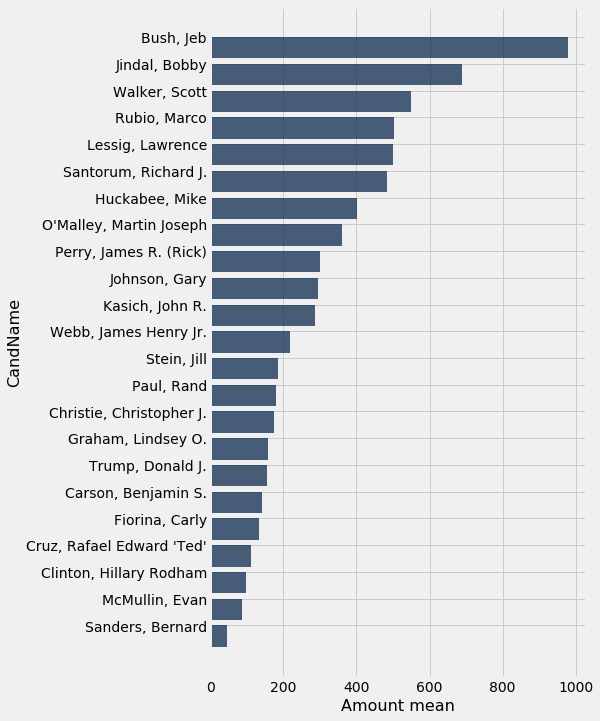

In [12]:
average_donations.barh(0)

#### I will now explore and directly compare Hillary's and Trump's contributions, looking for any insight that may help us understand the presidential election better.

In [13]:
trump = donations.where("CandName", "Trump, Donald J.")
clinton = donations.where("CandName", "Clinton, Hillary Rodham")

In [14]:
trump.show(3)

CandName,Date,Amount,ContOccupation,ContName,ElectionType
"Trump, Donald J.",15-SEP-16,$88.76,INFORMATION REQUESTED,"PUTNAM, MATTHEW",G2016
"Trump, Donald J.",20-NOV-16,$80.00,RETIRED,"SHARP, MARY MS.",G2016
"Trump, Donald J.",13-OCT-16,$28.00,RETIRED,"STAMPS, HAROLD MR.",G2016


In [15]:
clinton.show(3)

CandName,Date,Amount,ContOccupation,ContName,ElectionType
"Clinton, Hillary Rodham",11-APR-16,$115.00,HOMEMAKER,"CROSS, JOYCE",P2016
"Clinton, Hillary Rodham",13-APR-16,$40.00,INFORMATION REQUESTED,"BLANKS, NATHANIEL",P2016
"Clinton, Hillary Rodham",19-APR-16,$50.00,PROFESSOR,"TARVIN, WILLIAM",P2016


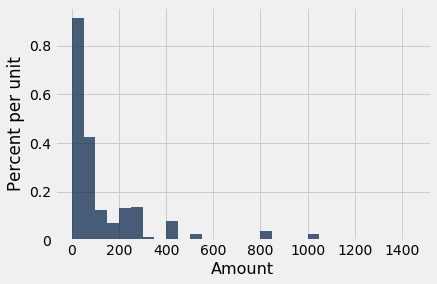

In [16]:
trump.hist(2, bins=np.arange(0, 1500, 50))

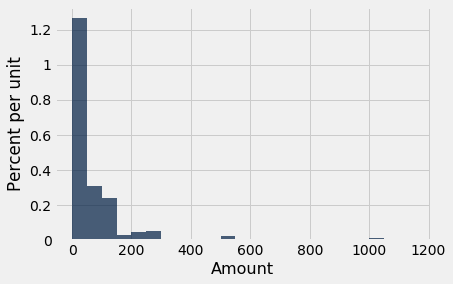

In [17]:
clinton.hist(2, bins=np.arange(0, 1200, 50))

### Let's examine the different types of people who donated to Trump and Clinton.

In [18]:
# Table of Trump contributors by occupation, sorted in descending order
trump_by_occupation = trump.select(2, 3).group("ContOccupation", sum).sort(1, descending=True).set_format(1, CurrencyFormatter)
trump_by_occupation

ContOccupation,Amount sum
RETIRED,"$619,921.47"
INFORMATION REQUESTED,"$361,345.82"
PHYSICIAN,"$73,307.69"
CEO,"$43,644.50"
BUSINESS OWNER,"$39,109.52"
OWNER,"$35,860.46"
SELF-EMPLOYED,"$34,282.33"
ENGINEER,"$33,766.76"
PRESIDENT,"$31,559.92"
HOMEMAKER,"$28,216.35"


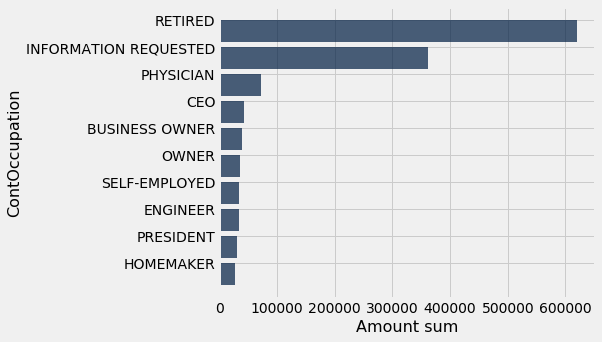

In [19]:
# Top 10 Trump Donators by Occupation
trump_by_occupation.take(np.arange(10)).barh(0)

In [20]:
# Table of Trump contributors by occupation, sorted in descending order
clinton_by_occupation = clinton.select(2, 3).group("ContOccupation", sum).sort(1, descending=True).set_format(1, CurrencyFormatter)
clinton_by_occupation

ContOccupation,Amount sum
RETIRED,"$386,446.10"
ATTORNEY,"$280,951.12"
INFORMATION REQUESTED,"$135,943.35"
LAWYER,"$58,556.36"
HOMEMAKER,"$52,704.31"
PHYSICIAN,"$47,819.40"
PROFESSOR,"$40,198.41"
CONSULTANT,"$26,794.88"
nan,"$25,735.64"
CEO,"$22,179.22"


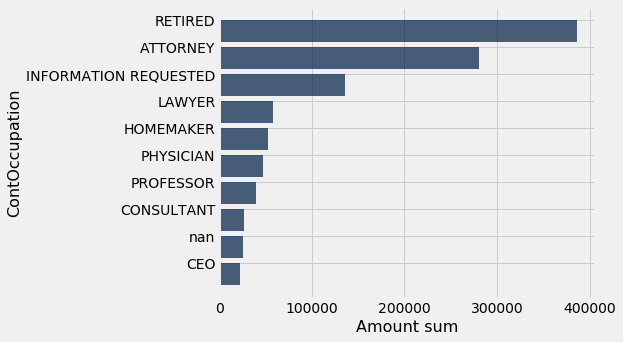

In [21]:
# Top 10 Clinton Donators by Occupation
clinton_by_occupation.take(np.arange(10)).barh(0)

#### As we can see, most people who donated to Trump were CEOs, bussiness owners, owners, self-employed, and engineers.
#### However, most people who donated to Clinton were attorneys, lawyers, homemakers, physicians, and professors.
This is consistent with what we expected.

### Now, I want to be able to graph the donations for each candidate over time. To do this, I need to return a list of sorted x and y pairs of the date and the contributions for that date. Let's define the following method to take in a dataframe and return exactly that.

In [22]:
from collections import defaultdict
import datetime as dt

In [23]:
def to_donation_xy_points(contributions):
    donations_dict = defaultdict(lambda:0)
    for r in range(contributions.num_rows):
        row = contributions.row(r)
        date = dt.datetime.strptime(row.item("Date"), '%d-%b-%y')
        donations_dict[date] += row.item("Amount")
    sorted_by_date = sorted(donations_dict.items())
    return zip(*sorted_by_date)

Let's call the method on Hillary's dataset, and plot the result.

In [24]:
hill_x, hill_y = to_donation_xy_points(clinton)

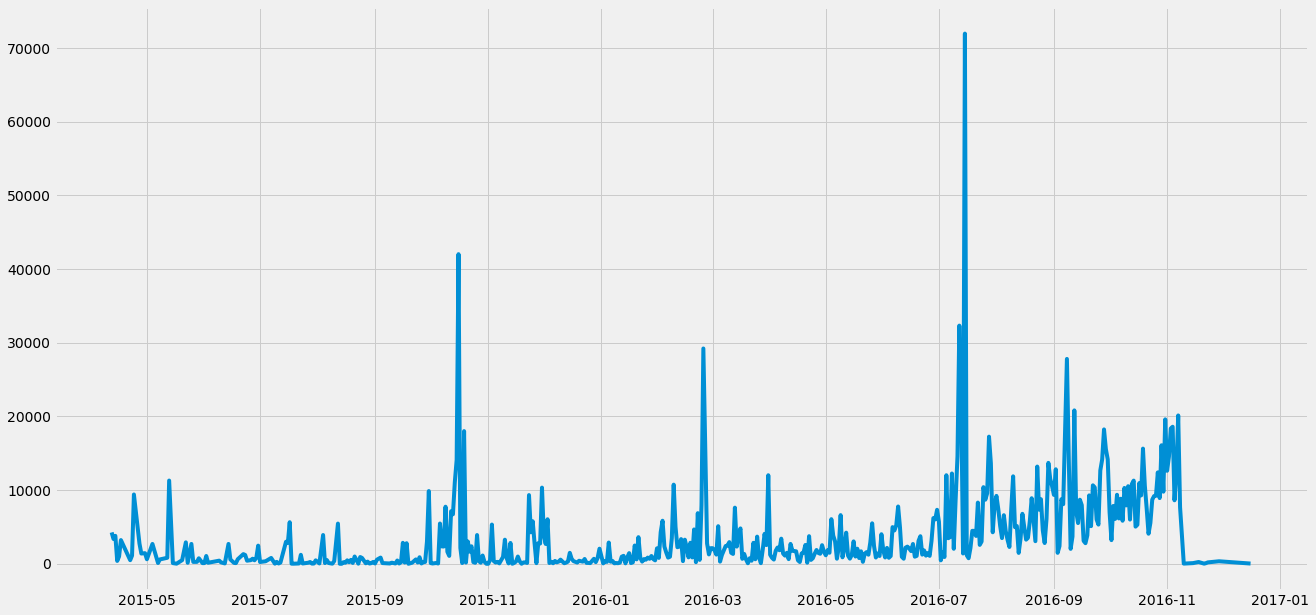

In [25]:
plots.figure(figsize=(20,10))
plots.plot(hill_x, hill_y)
plots.show()

We've just plotted all of Hillary's contributions over time. We see a few spikes at certain times. I did some Google searches at those dates and found that the first spike was clinton's dnc speech, the second was the first presidential debate, and the third was the first poll results of the debate.

Now let's do the same for Trump and plot both of their contributions side by side.

In [26]:
trump_x, trump_y = to_donation_xy_points(trump)

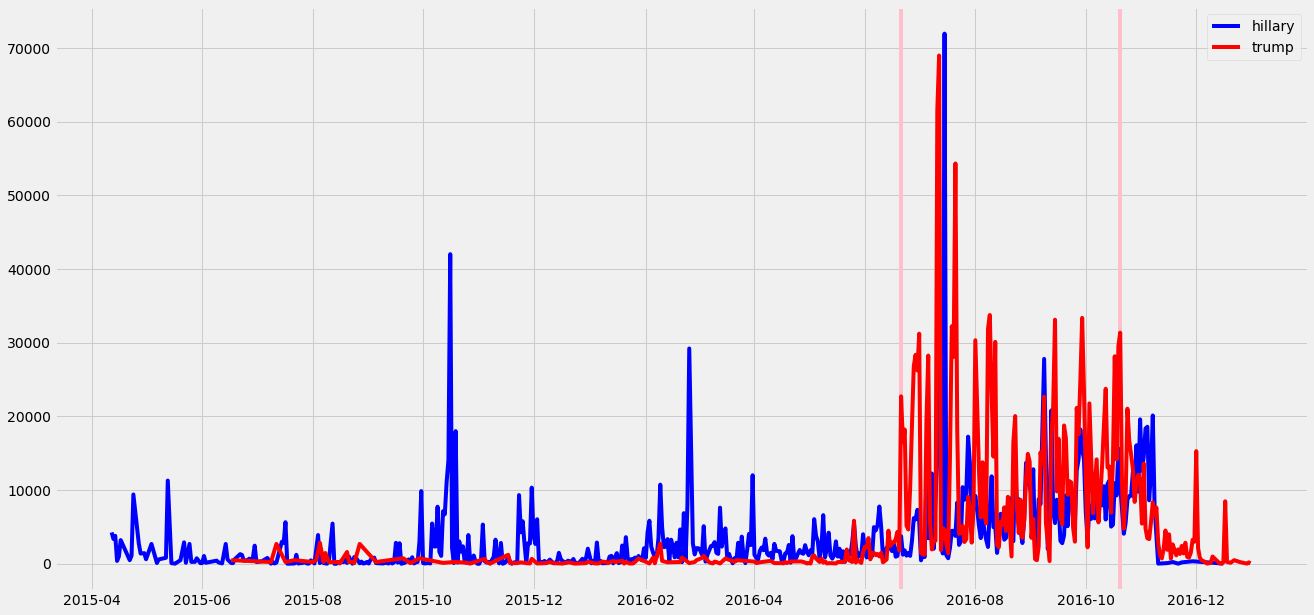

In [27]:
plots.figure(figsize=(20,10))
plots.axvline(x=dt.datetime(2016,6,21), c='pink') # trump speech at rnc
plots.axvline(x=dt.datetime(2016,10,20), c='pink') # presidential debate

plots.plot(hill_x, hill_y, label='hillary', c='blue')
plots.plot(trump_x, trump_y, label='trump', c='red')
plots.legend()
plots.show()

One thing we immediately see is that hillary has a more continuous, steady source of contributions, while Trump's seem to spike up a few months before the election. This probably has most to do with how trump lead his campaign and how really many didn't take him seriously until the end. Also, the major spikes from Trump's contributions happen at his RNC speech and at the last presidential debate, which is he rumored to have widely won. 

Below are some more plots regarding Trump.

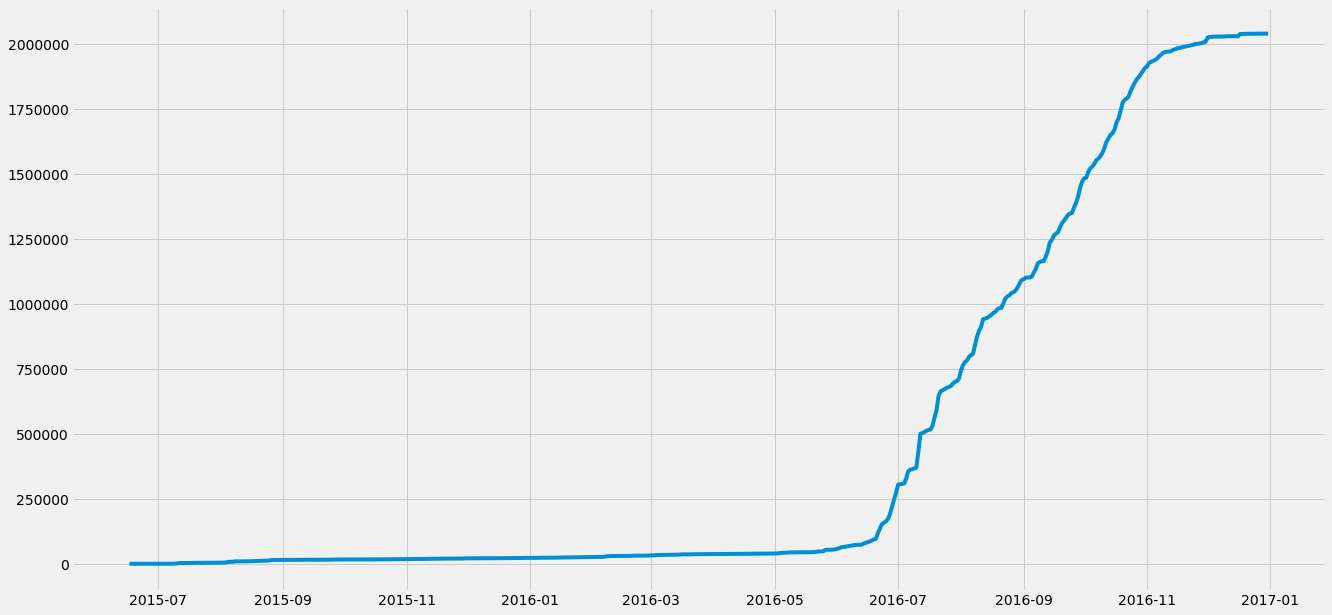

In [28]:
# Cumulative contributions for Donald Trump
plots.figure(figsize=(20,10))
plots.plot(trump_x, np.cumsum(trump_y))

(array([  4200.  ,   8301.5 ,   4569.02,   1689.14,   2810.45,   2638.37,
          6367.9 ,   6839.91,   2342.77,  21259.3 , 303281.41, 577302.22,
        321895.98, 521802.45, 214692.62,  39983.38]),
 array([735766.    , 735801.1875, 735836.375 , 735871.5625, 735906.75  ,
        735941.9375, 735977.125 , 736012.3125, 736047.5   , 736082.6875,
        736117.875 , 736153.0625, 736188.25  , 736223.4375, 736258.625 ,
        736293.8125, 736329.    ]),
 <a list of 16 Patch objects>)

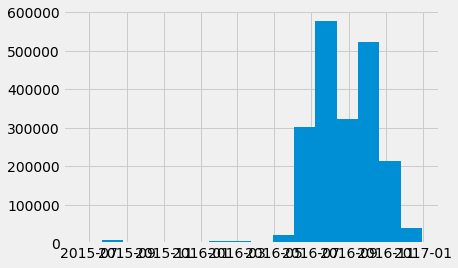

In [29]:
# Histogram of the contributions (not cumulative), with a bin for each month
plots.hist(trump_x, bins=16, weights=trump_y)  # for 16 months

## Joining

Now I'm going to merge the two tables I have by the candidate names and see analyze the different political parties.

In [30]:
donations.show(3)

CandName,Date,Amount,ContOccupation,ContName,ElectionType
"Trump, Donald J.",15-SEP-16,$88.76,INFORMATION REQUESTED,"PUTNAM, MATTHEW",G2016
"Clinton, Hillary Rodham",11-APR-16,$115.00,HOMEMAKER,"CROSS, JOYCE",P2016
"Trump, Donald J.",20-NOV-16,$80.00,RETIRED,"SHARP, MARY MS.",G2016


In [31]:
candidates.show(3)

cand_id,cand_nm,cand_nm_title,cand_pty_aff,contb_receipt_amt,ind_contrib,pac_contrib,party_contrib,cand_contrib,disbursements,coh_cop,other_contrib,debt,date_through,election_yr
P00003392,"Clinton, Hillary Rodham","Clinton, Hillary Rodham",Democratic Party,"$563,754,017","$399,669,230","$1,783,251","$20,039","$1,450,335","$563,430,700","$323,317","$160,831,162",$183,12/31/16,2016
P80001571,"Trump, Donald J.","Trump, Donald J.",Republican Party,"$333,127,164","$132,233,015","$144,534","$9,303","$66,141,714","$325,334,388","$7,611,703","$134,598,598",$0,12/31/16,2016
P60007168,"Sanders, Bernard","Sanders, Bernard",Democratic Party,"$228,164,501","$226,581,901","$5,622",$0,$0,"$222,709,340","$5,473,008","$1,576,978","$449,409",12/31/16,2016


In [32]:
candidates_party = candidates.select("cand_nm", "cand_pty_aff")
candidates_party.show(5)

cand_nm,cand_pty_aff
"Clinton, Hillary Rodham",Democratic Party
"Trump, Donald J.",Republican Party
"Sanders, Bernard",Democratic Party
"Cruz, Rafael Edward 'Ted'",Republican Party
"Carson, Benjamin S.",Republican Party


In [33]:
donations_with_party = donations.join("CandName", candidates_party, "cand_nm")
donations_with_party.show(5)

CandName,Date,Amount,ContOccupation,ContName,ElectionType,cand_pty_aff
"Bush, Jeb",08-JAN-16,$25.00,RETIRED,"JENRETTE, ALBERT",P2016,Republican Party
"Bush, Jeb",18-JAN-16,$25.00,RETIRED,"JENRETTE, ALBERT",P2016,Republican Party
"Bush, Jeb",28-JAN-16,$50.00,NONE,"LEDDICK, ERIC",P2016,Republican Party
"Bush, Jeb",23-JAN-16,$25.00,REAL ESTATE BROKER,"PERREAULT, JENNIFER",P2016,Republican Party
"Bush, Jeb",31-JAN-16,$15.00,REAL ESTATE BROKER,"PERREAULT, JENNIFER",P2016,Republican Party


In [34]:
donations_with_party = donations_with_party.relabeled(6, "Party")
donations_with_party.show(3)

CandName,Date,Amount,ContOccupation,ContName,ElectionType,Party
"Bush, Jeb",08-JAN-16,$25.00,RETIRED,"JENRETTE, ALBERT",P2016,Republican Party
"Bush, Jeb",18-JAN-16,$25.00,RETIRED,"JENRETTE, ALBERT",P2016,Republican Party
"Bush, Jeb",28-JAN-16,$50.00,NONE,"LEDDICK, ERIC",P2016,Republican Party


In [35]:
grouped_by_party = donations_with_party.select(2, 6).group("Party", np.sum).sort("Amount sum", descending=True)
grouped_by_party.set_format(1, CurrencyFormatter)

Party,Amount sum
Republican Party,"$4,745,019.72"
Democratic Party,"$2,263,411.97"
Libertarian Party,"$25,728.70"
Green Party,"$7,077.00"
Independent Party,"$1,930.00"


Republican Party has the most amount of donations followed by the Democratic Party. The Republican Party has almost twice as much donations as the Democratic Party.

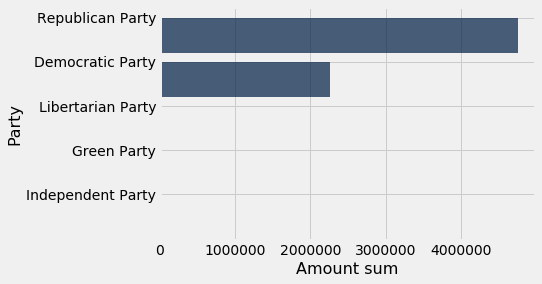

In [36]:
grouped_by_party.barh(0)

## Hypothesis Testing

#### Now I'm going to see whether there is any correlation between Trump's tweets and his campaign donations. In order to do this I need to add one more dataset to this project: Trump's tweets!

The following data was taken from http://www.trumptwitterarchive.com/archive

In [37]:
tweets = Table.read_table("Data/trump-tweets.csv")
tweets.show(5)

source,text,created_at,retweet_count,favorite_count,is_retweet
Twitter for Android,So I raised/gave $5600000 for the veterans and the media ...,06-01-2016 13:17:58,9381,29810,False
Twitter for iPhone,Join me in San Jose California- tomorrow evening at 7pm! ...,06-01-2016 20:46:38,3245,9350,False
Twitter for Android,Crooked Hillary Clinton is a fraud who has put the publi ...,06-01-2016 22:16:36,9816,27248,False
Twitter for iPhone,"Same failing @nytimes ""reporter"" who wrote discredited w ...",06-02-2016 00:21:01,4026,13160,False
Twitter for iPhone,Thank you Sacramento California! #MakeAmericaGreatAgain ...,06-02-2016 04:58:34,5147,16491,False


Before maknig a hypothesis test, I'm going to do some visualizations on the dataset.

After doing some searches I found that both Trump and his staff tweet from the same account. But, Trump tweets from Android, while his staff tweets from iPhone. We can exploit this to look at differences in the tweets.

In [38]:
android = tweets.where("source", are.containing("Android"))
iphone = tweets.where("source", are.containing("iPhone"))

In [39]:
android.show(5)

source,text,created_at,retweet_count,favorite_count,is_retweet
Twitter for Android,So I raised/gave $5600000 for the veterans and the media ...,06-01-2016 13:17:58,9381,29810,False
Twitter for Android,Crooked Hillary Clinton is a fraud who has put the publi ...,06-01-2016 22:16:36,9816,27248,False
Twitter for Android,@SCPioneer: @stockdaleism @JamesRosenFNC @FoxNews @realD ...,06-02-2016 05:11:16,1935,6899,False
Twitter for Android,@HaloDad22: @realDonaldTrump I already voted for you! My ...,06-02-2016 22:18:50,2776,9057,False
Twitter for Android,@TaylorEdwards99: THIS IS @POTUS'S LEGACY! AN ABSOLUTE D ...,06-02-2016 22:22:20,2493,8602,False


In [40]:
iphone.show(5)

source,text,created_at,retweet_count,favorite_count,is_retweet
Twitter for iPhone,Join me in San Jose California- tomorrow evening at 7pm! ...,06-01-2016 20:46:38,3245,9350,False
Twitter for iPhone,"Same failing @nytimes ""reporter"" who wrote discredited w ...",06-02-2016 00:21:01,4026,13160,False
Twitter for iPhone,Thank you Sacramento California! #MakeAmericaGreatAgain ...,06-02-2016 04:58:34,5147,16491,False
Twitter for iPhone,RT @IvankaTrump: Beautiful article about @realDonaldTrum ...,06-03-2016 01:12:12,2762,0,True
Twitter for iPhone,.@Natalie_Gulbis- Thank you for the nice piece in @SInow ...,06-03-2016 01:13:19,1836,6459,False


we can see how many times Trump tweeted about Hillary vs his staff.

In [41]:
print("Trump: " + str(android.where("text", are.containing("Hillary")).num_rows))

Trump: 161


In [42]:
print("His Staff: " + str(iphone.where("text", are.containing("Hillary")).num_rows))

His Staff: 145


We can create a barplot for the relative frequency of various search terms. Let's try some famous ones, like sad, crooked, and jobs.

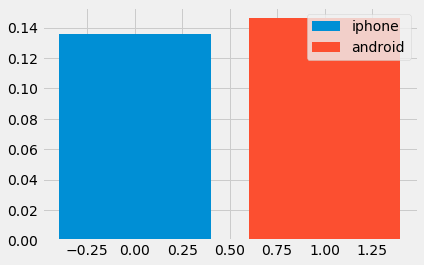

In [43]:
search_string = 'Clinton' # crooked, sad, lies, jobs business
plots.bar(0, iphone.where("text", are.containing(search_string)).num_rows / iphone.num_rows, label='iphone')
plots.bar(1, android.where("text", are.containing(search_string)).num_rows / android.num_rows, label='android')
plots.legend()
plots.show()

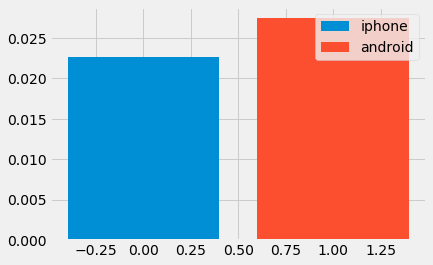

In [44]:
search_string = 'lies' # crooked, sad, lies, jobs business
plots.bar(0, iphone.where("text", are.containing(search_string)).num_rows / iphone.num_rows, label='iphone')
plots.bar(1, android.where("text", are.containing(search_string)).num_rows / android.num_rows, label='android')
plots.legend()
plots.show()

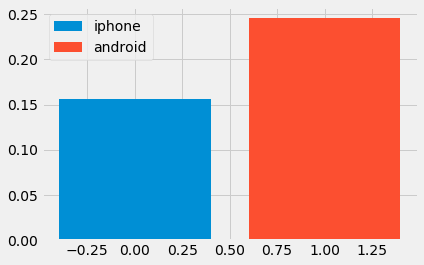

In [45]:
search_string = 'Hillary' # crooked, sad, lies, jobs business
plots.bar(0, iphone.where("text", are.containing(search_string)).num_rows / iphone.num_rows, label='iphone')
plots.bar(1, android.where("text", are.containing(search_string)).num_rows / android.num_rows, label='android')
plots.legend()
plots.show()

After trying different words, we can see that Trump tweets a lot more than his staff about sadness, lies, and Hillary. :)

#### Now back to Hypothesis testing.

**Null hypothesis:** There is no correlation between Trump's tweets and his campaign donations. Meaning that it is just as likely that tweets affected his campaign donations as they they did not. (50-50 percent chance)

**Alternative hypothesis:** There is correlation between Trump's tweets and his campaign donations. (Not 50-50 percent chance)

In [46]:
def change_date(s):
    month = ""
    m_part = s[3:6]
    if m_part == "JAN":
        month = "01"
    elif m_part == "FEB":
        month = "02"
    elif m_part == "MAR":
        month = "03"
    elif m_part == "APR":
        month = "04"
    elif m_part == "MAY":
        month = "05"
    elif m_part == "JUN":
        month = "06"
    elif m_part == "JUL":
        month = "07"
    elif m_part == "AUG":
        month = "08"
    elif m_part == "SEP":
        month = "09"
    elif m_part == "OCT":
        month = "10"
    elif m_part == "NOV":
        month = "11"
    elif m_part == "DEC":
        month = "12"
    return month + "-" + s[0:2] + "-" + "20" + s[7:9]

In [47]:
donations = donations.with_column("Date", donations.apply(change_date, "Date"))
donations

CandName,Date,Amount,ContOccupation,ContName,ElectionType
"Trump, Donald J.",09-15-2016,$88.76,INFORMATION REQUESTED,"PUTNAM, MATTHEW",G2016
"Clinton, Hillary Rodham",04-11-2016,$115.00,HOMEMAKER,"CROSS, JOYCE",P2016
"Trump, Donald J.",11-20-2016,$80.00,RETIRED,"SHARP, MARY MS.",G2016
"Trump, Donald J.",10-13-2016,$28.00,RETIRED,"STAMPS, HAROLD MR.",G2016
"Trump, Donald J.",10-20-2016,$28.00,RETIRED,"STAMPS, HAROLD MR.",G2016
"Trump, Donald J.",10-27-2016,$28.00,RETIRED,"STAMPS, HAROLD MR.",G2016
"Sanders, Bernard",03-06-2016,$15.00,NOT EMPLOYED,"HENDRICKS, ASHLEY",P2016
"Clinton, Hillary Rodham",04-13-2016,$40.00,INFORMATION REQUESTED,"BLANKS, NATHANIEL",P2016
"Trump, Donald J.",11-30-2016,$80.00,SALES REP,"THOMAS, MATTHEW",G2016
"Trump, Donald J.",11-26-2016,$63.14,INFORMATION REQUESTED,"MAYO, GREGORY",G2016


In [48]:
def remove_time(s):
    return s[:10]
tweets = tweets.with_column("created_at", tweets.apply(remove_time, "created_at"))
tweets = tweets.select("created_at", "retweet_count", "favorite_count", "is_retweet")
tweets

created_at,retweet_count,favorite_count,is_retweet
06-01-2016,9381,29810,False
06-01-2016,3245,9350,False
06-01-2016,9816,27248,False
06-02-2016,4026,13160,False
06-02-2016,5147,16491,False
06-02-2016,1935,6899,False
06-02-2016,2776,9057,False
06-02-2016,2493,8602,False
06-02-2016,2626,9262,False
06-03-2016,2762,0,True


In [49]:
grouped_tweets = tweets.group(0, sum)
grouped_tweets

created_at,retweet_count sum,favorite_count sum,is_retweet sum
06-01-2016,22442,66408,0
06-02-2016,19003,63471,0
06-03-2016,74062,216024,1
06-04-2016,69170,160926,1
06-05-2016,26070,72515,0
06-06-2016,58891,160116,1
06-07-2016,24547,67485,0
06-08-2016,60780,178252,1
06-09-2016,265815,581123,0
06-10-2016,105682,256954,0


In [50]:
trump = donations.where("CandName", "Trump, Donald J.")
trump = trump.select("Date", "Amount")
trump_new = trump.group("Date", np.sum).relabeled(1, "Amount").set_format(1, CurrencyFormatter)
trump_new

Date,Amount
01-04-2016,$50.00
01-06-2016,$58.45
01-07-2016,$198.98
01-08-2016,$303.32
01-10-2016,$250.00
01-11-2016,$80.88
01-14-2016,$412.85
01-15-2016,$250.00
01-19-2016,$433.20
01-20-2016,$37.62


In [51]:
tweeted = make_array()
for i in range(trump_new.num_rows):
    if trump_new.row(i).item("Date") in grouped_tweets.column(0):
        tweeted = np.append(tweeted, True)
    else:
        tweeted = np.append(tweeted, False)
tweeted

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1.

In [52]:
trump_with_tweets = trump_new.with_column("Tweeted", tweeted)
trump_with_tweets

Date,Amount,Tweeted
01-04-2016,$50.00,0
01-06-2016,$58.45,0
01-07-2016,$198.98,0
01-08-2016,$303.32,0
01-10-2016,$250.00,0
01-11-2016,$80.88,0
01-14-2016,$412.85,0
01-15-2016,$250.00,0
01-19-2016,$433.20,0
01-20-2016,$37.62,0


In [53]:
observed = np.abs(trump_with_tweets.where("Tweeted", 1).column("Amount").mean() - 
            trump_with_tweets.where("Tweeted", 0).column("Amount").mean())
observed

9321.47865244458

In [54]:
def statistic(table):
    """Takes in a table like trump_with_tweets and computes the test statistic by
    taking the the absolute value of the difference of the mean of donations when a tweet was made 
    and the mean of donations when a tweet wasn't made.
    """
    did_tweet = table.where("Tweeted", 1).column("Amount").mean()
    did_not_tweet = table.where("Tweeted", 0).column("Amount").mean()
    return np.abs(did_tweet - did_not_tweet)

In [55]:
def simulate():
    """Performs the test statistics on trump_with_tweets for 5000 iterations.
        The samples are drawn with replacements, each having the same size.
    """
    result = make_array()
    for _ in range(5000):
        sample = trump_with_tweets.sample()
        stat = statistic(sample)
        result = np.append(result, stat)
    return result

In [56]:
simulation = simulate()

In [57]:
sum(simulation >= observed) / 5000

0.495

#### Since the p-value is very large, we accept the null hypothesis and therefore reject the alternative hypothesis. As a result, we can conclude that Trump's tweets had no affect on his campaign donations.

## Predictions

### In this section, I'm going to make a model to predict Trump's total campaign donaiton on a day based on the total number of retweets he got on that day!

In [58]:
def convert_to_int(s):
    return int((s[1:]).replace(",",""))

In [59]:
candidates = candidates.with_columns("contb_receipt_amt", candidates.apply(convert_to_int, 4),
                                     "ind_contrib", candidates.apply(convert_to_int, 5),
                                     "pac_contrib", candidates.apply(convert_to_int, 6),
                                     "party_contrib", candidates.apply(convert_to_int, 7),
                                     "cand_contrib", candidates.apply(convert_to_int, 8)
                                    )

In [60]:
color_table = Table().with_columns(
    'cand_pty_aff', make_array("Democratic Party", "Republican Party"),
    'Color', make_array('darkblue', 'gold')
)

In [61]:
candidates = candidates.join("cand_pty_aff", color_table)

In [62]:
joined = trump_new.join("Date", tweets, "created_at")
joined

Date,Amount,retweet_count,favorite_count,is_retweet
06-01-2016,"$2,322.23",9381,29810,False
06-01-2016,"$2,322.23",3245,9350,False
06-01-2016,"$2,322.23",9816,27248,False
06-02-2016,"$2,266.00",4026,13160,False
06-02-2016,"$2,266.00",5147,16491,False
06-02-2016,"$2,266.00",1935,6899,False
06-02-2016,"$2,266.00",2776,9057,False
06-02-2016,"$2,266.00",2493,8602,False
06-02-2016,"$2,266.00",2626,9262,False
06-03-2016,"$3,497.75",2762,0,True


In [63]:
tweet_donation = joined.group(0, sum)
tweet_donation

Date,Amount sum,retweet_count sum,favorite_count sum,is_retweet sum
06-01-2016,6966.69,22442,66408,0
06-02-2016,13596,19003,63471,0
06-03-2016,69955,74062,216024,1
06-04-2016,5508,69170,160926,1
06-05-2016,4290,26070,72515,0
06-06-2016,14974.1,58891,160116,1
06-07-2016,4763.04,24547,67485,0
06-08-2016,21350.9,60780,178252,1
06-09-2016,13078,265815,581123,0
06-10-2016,20960.2,105682,256954,0


In [64]:
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)

In [66]:
df = tweet_donation.with_column("Amount sum", standard_units(tweet_donation.column(1)),
                                "retweet_count sum", standard_units(tweet_donation.column(2)),
                                "favorite_count sum", standard_units(tweet_donation.column(3))
                               )

In [67]:
df

Date,Amount sum,retweet_count sum,favorite_count sum,is_retweet sum
06-01-2016,-0.476551,-0.805035,-0.920884,0
06-02-2016,-0.452353,-0.835988,-0.932389,0
06-03-2016,-0.246633,-0.340425,-0.334803,1
06-04-2016,-0.481876,-0.384456,-0.550635,1
06-05-2016,-0.486322,-0.772381,-0.896962,0
06-06-2016,-0.447323,-0.476973,-0.553808,1
06-07-2016,-0.484595,-0.786089,-0.916665,0
06-08-2016,-0.424047,-0.459971,-0.482765,1
06-09-2016,-0.454244,1.38546,1.09538,0
06-10-2016,-0.425472,-0.0558268,-0.174471,0


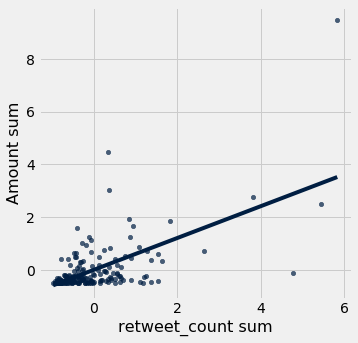

In [68]:
df.scatter(2, 1, fit_line=True)

As we can see, the data has a linear pattern to it, therefore I'm going to apply linear regression.

In [69]:
tweet_donation

Date,Amount sum,retweet_count sum,favorite_count sum,is_retweet sum
06-01-2016,6966.69,22442,66408,0
06-02-2016,13596,19003,63471,0
06-03-2016,69955,74062,216024,1
06-04-2016,5508,69170,160926,1
06-05-2016,4290,26070,72515,0
06-06-2016,14974.1,58891,160116,1
06-07-2016,4763.04,24547,67485,0
06-08-2016,21350.9,60780,178252,1
06-09-2016,13078,265815,581123,0
06-10-2016,20960.2,105682,256954,0


In [70]:
tweet_donation = tweet_donation.select(2, 1)

In [71]:
tweet_donation

retweet_count sum,Amount sum
22442,6966.69
19003,13596
74062,69955
69170,5508
26070,4290
58891,14974.1
24547,4763.04
60780,21350.9
265815,13078
105682,20960.2


In [72]:
tweet_donation = tweet_donation.relabeled(make_array("Amount sum", "retweet_count sum"), make_array("amount_donated", "retweets"))
tweet_donation

retweets,amount_donated
22442,6966.69
19003,13596
74062,69955
69170,5508
26070,4290
58891,14974.1
24547,4763.04
60780,21350.9
265815,13078
105682,20960.2


In [73]:
def correlation(tbl):
    return np.mean(standard_units(tbl.column(0)) * standard_units(tbl.column(1)))

In [74]:
x = tweet_donation.column(0)
y = tweet_donation.column(1)

The correlation coefficient is high too, which indicated linear associativity.

In [75]:
correlation(tweet_donation)

0.6038707619866448

In [76]:
def fit_line(tbl):
    X = tbl.column(0)
    y = tbl.column(1)
    r = correlation(tbl)
    slope = r * np.std(y) / np.std(X)
    intercept = np.mean(y) - slope * np.mean(X)
    return make_array(slope, intercept)

In [77]:
slope, intercept = fit_line(tweet_donation)
slope, intercept

(1.4890173017855814, -29075.92549952175)

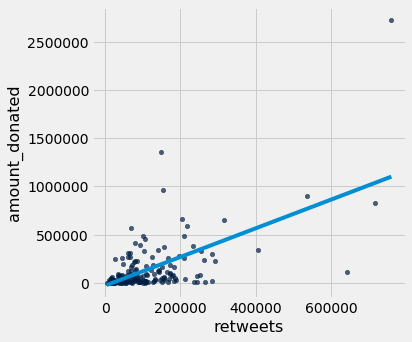

In [78]:
tweet_donation.scatter(0)
plots.plot([min(tweet_donation[0]), max(tweet_donation[0])], 
         [slope*min(tweet_donation[0])+intercept, slope*max(tweet_donation[0])+intercept])
plots.show()

For example, if we wanted to predict how much donation Trump would get if he got around x total retweets on a day, we could use the function below.

In [79]:
def predict(x):
    return slope * x + intercept

In [80]:
# predicting if he got 200000 retweets
p = predict(200000)
p

268727.5348575945

He would get around $268,727 on campaign donations on that day! 

### Let's evaluate our model!

In [81]:
def residuals(tbl, slope, intercept):
    error = tbl.column(1) - (slope*tbl.column(0) + intercept)
    return error

In [82]:
residual_table = tweet_donation.with_columns("Residuals", residuals(tweet_donation, slope, intercept))
residual_table

retweets,amount_donated,Residuals
22442,6966.69,2626.09
19003,13596,14376.1
74062,69955,-11248.7
69170,5508,-68411.4
26070,4290,-5452.76
58891,14974.1,-43639.7
24547,4763.04,-2711.94
60780,21350.9,-40075.7
265815,13078,-353649
105682,20960.2,-107326


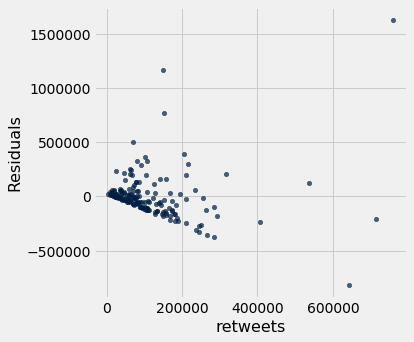

In [83]:
residual_table.scatter(0, 2)

As we can see, most of the points lie around 0 on the y axix which means that are error is low. However we see some points that are very far from 0, and those are beacuse of the outliers we had in our original data set.